In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\Artem\AppData\Local\Temp\ipykernel_8184\3385269794.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
USD = Asset.make_USD()
BTC = Asset('BTC')
#BTC.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
ETH = Asset('ETH')
#ETH.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
USDT = Asset('USDT')
#USDT.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-01-01'), date_to = tmpstemp('2024-03-31'))

In [3]:
class Strategy:

    def __init__(self, model_input_length = 15):
        self.frequency = 1
        self.model = Model()
        self.input_span = model_input_length
        self.scaler = MinMaxScaler(feature_range=(0,1))

    def make_suggestion(self, today, portfolio):
        risk_rate = 0.02
        fee_rate = 0.006
        
        positions = portfolio.get_positions(today)
        suggestions = pd.DataFrame(columns = ['change_in_size', 'USD_value', 'note'], index = positions.index)
        data_to_process = BTC.history['close'].loc[today-tmpdelta(days=self.input_span-1):today+tmpdelta(days=1)]
        prediction = self.predict_one(data_to_process)
        prediction = float(prediction['Predicted price'])
        print(prediction)

        # If BTC is predicted to go up - buy it
        if prediction > float(BTC.price_on_date(today)):
            USD_to_spend = risk_rate * positions['position_value'].loc['USD']  # In this strategy, we change position by risk_rate% on every step
            ext_price = USD_to_spend/(1 + fee_rate)                    # This is how much will be paid for BTC, extended price
            fees = USD_to_spend - ext_price                            # This is plaform fees
            BTC_price = BTC.history['close'].loc[today]                # BTC price at the time of decision
            BTC_to_buy = ext_price/BTC_price
            suggestions.loc['BTC'] = [BTC_to_buy, ext_price, 'Buy BTC']
            suggestions.loc['USD'] = [-USD_to_spend,-USD_to_spend, 'BTC price w fees']

        # If BTC is predicted to go down - sell it
        if prediction < float(BTC.price_on_date(today)):
            BTC_to_spend = risk_rate * positions['position_size'].loc['BTC']  # In this strategy, we change position by risk_rate% on every step
            ext_price = BTC_to_spend/(1 + fee_rate)                    # This is how much BTC will be sold, extended price
            fees = BTC_to_spend - ext_price                            # This is plaform fees
            BTC_price = BTC.history['close'].loc[today]                # BTC price at the time of decision
            USD_to_buy = ext_price*BTC_price
            suggestions.loc['BTC'] = [-BTC_to_spend, -BTC_to_spend, 'Sell BTC w fees']
            suggestions.loc['USD'] = [USD_to_buy, USD_to_buy, 'BTC sale']
            suggestions.dropna(inplace=True)

        return suggestions

    def backtest(self, hist_data: pd.DataFrame, portfolio: Portfolio):
        updated_portfolio = Portfolio()
        return updated_portfolio
    
    def predict_batch(self, data_to_process):
        '''
        Given the new data go one time point after another and make predictions
        '''
        prediction_prices = []
        pred_prices_idx = []
        for tomorrow_date in data_to_process.index[(self.input_span-1):]:
            try:
                # range(tomorrow - 14: tomorrow) is 15 day-log timespan that end today!
                current_day_input = data_to_process.loc[tomorrow_date - tmpdelta(days=self.input_span-1):tomorrow_date]  # Data slice to be used in this step
                model_input = self.scaler.transform(np.array(current_day_input.values).reshape(-1,1) )     # Data scaled as input for the model
                model_input = np.array(model_input).reshape(-1, model_input.shape[0], model_input.shape[1])                           # Data shaped as input for the model
                tmr_BTC_price = self.model.predict(model_input,verbose = 0)                                # Predict
                tmr_BTC_price = self.scaler.inverse_transform(tmr_BTC_price)[0][0]                         # Un-scale to get predicted asset price
                prediction_prices.append(tmr_BTC_price)                                               # Save the result in the output array
                pred_prices_idx.append(tomorrow_date)

                # Format string for output
                today_day = tomorrow_date-tmpdelta(days=1)                      # Get date we are predictig for 
                today_BTC_price = data_to_process.loc[today_day]                                             # Get current asset price 
                # print(f'Today ({today_day}):{today_BTC_price}, predicted for {tomorrow_date}: {tmr_BTC_price}')
            except Exception as e:
                print(e)
                pass
        return pd.DataFrame(data=prediction_prices, columns = ['Predicted price'], index = pd.DatetimeIndex(pred_prices_idx, name='date_time'))

    def predict_one(self, data_to_process):
        '''
        Given the data predict for the next timepoint
        '''
        tomorrow_date = data_to_process.index[-1]+tmpdelta(days=1)
        today_day = data_to_process.index[-1]
        today_BTC_price = data_to_process.loc[today_day] 
        try:
            model_input = self.scaler.transform(np.array(data_to_process.values).reshape(-1,1) )     # Data scaled as input for the model
            model_input = np.array(model_input).reshape(-1, model_input.shape[0], model_input.shape[1])# Data shaped as input for the model
            tmr_BTC_price = self.model.predict(model_input,verbose = 0)                                # Predict
            tmr_BTC_price = self.scaler.inverse_transform(tmr_BTC_price)[0][0]                         # Un-scale to get predicted asset price

            print(f'Today ({today_day}):{today_BTC_price}, predicted for {tomorrow_date}: {tmr_BTC_price}')
        except Exception as e:
            print(e)
            pass
        return pd.DataFrame(data=[tmr_BTC_price],
                            columns = ['Predicted price'],
                            index = pd.DatetimeIndex([tomorrow_date], name='date_time'))

    def train_val_split_scale(self, df):
        len_train = int(0.7*len(df))
        X = []
        y = []
        scaled_data = self.scaler.fit_transform(np.array(df['close'].values).reshape(-1,1) )
        for x in range(self.input_span, len(df)):
            X.append(scaled_data[x-self.input_span:x, 0])
            y.append(scaled_data[x,0])
        X, y = (np.array(X), np.array(y))
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        train_idx = df.index[self.input_span:len_train]
        val_index = df.index[len_train:]
        print(f'from {train_idx[0]} to {train_idx[-1]}')
        return X[0:len_train-self.input_span,:,:], y[0:len_train-self.input_span], train_idx, X[len_train-self.input_span:,:,:], y[len_train-self.input_span:], val_index

In [4]:
naive_LSTM = Strategy(model_input_length = 15)
date_from = tmpstemp('2022-01-01')
x_train, y_train, train_idx, x_val, y_val, val_idx = naive_LSTM.train_val_split_scale(BTC.history.loc[date_from:])

from 2022-01-16 19:00:00 to 2023-07-28 20:00:00


In [5]:
hidden_size = 50
dropout = 0.3
learning_rate = 0.0005

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = 'input')

LSTM1 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM1' )(input_layer)
LSTM1 = Dropout(dropout)(LSTM1)

LSTM2 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM2' )(LSTM1)
LSTM2 = Dropout(dropout)(LSTM2)

LSTM3 = LSTM(units = 50, activation='tanh', name = 'LSTM3' )(LSTM2)
LSTM3 = Dropout(dropout)(LSTM3)

hidden1 = Dense(hidden_size, activation='relu', name='hidden_layer1')(LSTM3)
hidden1 = Dropout(dropout)(hidden1)


# Create output layer
out = Dense(1, activation='linear', name = 'Regression_layer')(hidden1)
model = Model(inputs=[input_layer], outputs=out)


model.compile(optimizer=Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])
naive_LSTM.model = model
naive_LSTM.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 LSTM1 (LSTM)                (None, 15, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 15, 50)            0         
                                                                 
 LSTM2 (LSTM)                (None, 15, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 15, 50)            0         
                                                                 
 LSTM3 (LSTM)                (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0   

In [6]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

naive_LSTM.model.fit([x_train], y_train, 
          validation_data=([x_val], y_val),
          epochs=20, batch_size=64,
          callbacks=[early_stopping])


Epoch 1/20
9/9 [==============================] - 12s 337ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - val_loss: 0.1861 - val_mean_squared_error: 0.1861
Epoch 2/20
9/9 [==============================] - 1s 71ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.1001 - val_mean_squared_error: 0.1001
Epoch 3/20
9/9 [==============================] - 1s 69ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 4/20
9/9 [==============================] - 1s 69ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 5/20
9/9 [==============================] - 1s 67ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 6/20
9/9 [==============================] - 1s 67ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 7/20
9/9 [============================

In [7]:
pred_df = naive_LSTM.predict_batch(data_to_process = BTC.history['close'].loc[val_idx[0]-tmpdelta(days=15):])

Timestamp('2023-11-04 19:00:00')
Timestamp('2024-03-09 20:00:00')


In [8]:
'''
predicted = {}
current = {}

# Given the new data go one time point after another and make predictions 
for x in range(1,len(val_idx)):
    model_input = x_val[x,:,:].reshape(1,input_span,1)                       # Data shaped as input for the model
    pred_BTC_price = naive_LSTM.model.predict(model_input, verbose=0)                                # Predict
    pred_BTC_price = scaler.inverse_transform(pred_BTC_price)[0][0]                        # Un-scale to get predicted asset price

    # Format string for output
    current_date = val_idx[x-1]
    predicted_for_date = val_idx[x]                   # Get date we are predictig for 
    curr_BTC_price = BTC.history['close'].loc[current_date]                                             # Get current asset price 
    #print(f'Today ({val_idx[x]}):{curr_BTC_price}, predicted for {predicted_for_date}: {pred_BTC_price}')
    predicted[predicted_for_date] = pred_BTC_price
    current[current_date] = curr_BTC_price                                               # Save the result in the output array
predicted_df = pd.DataFrame(columns = ['predicted'], data = predicted.values(), index = pd.DatetimeIndex(predicted.keys(), name = 'date_time'))
current_df = pd.DataFrame(columns = ['current'], data = current.values(), index = pd.DatetimeIndex(current.keys(), name = 'date_time'))
df_to_plot = pd.merge(current_df, predicted_df, left_index=True, right_index=True)
df_to_plot.head()
'''

"\npredicted = {}\ncurrent = {}\n\n# Given the new data go one time point after another and make predictions \nfor x in range(1,len(val_idx)):\n    model_input = x_val[x,:,:].reshape(1,input_span,1)                       # Data shaped as input for the model\n    pred_BTC_price = naive_LSTM.model.predict(model_input, verbose=0)                                # Predict\n    pred_BTC_price = scaler.inverse_transform(pred_BTC_price)[0][0]                        # Un-scale to get predicted asset price\n\n    # Format string for output\n    current_date = val_idx[x-1]\n    predicted_for_date = val_idx[x]                   # Get date we are predictig for \n    curr_BTC_price = BTC.history['close'].loc[current_date]                                             # Get current asset price \n    #print(f'Today ({val_idx[x]}):{curr_BTC_price}, predicted for {predicted_for_date}: {pred_BTC_price}')\n    predicted[predicted_for_date] = pred_BTC_price\n    current[current_date] = curr_BTC_price        

In [9]:
my_portfolio = Portfolio(origination_date=(pred_df.index[0] - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(pred_df.index[0] - tmpdelta(days=1)))
my_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(pred_df.index[0] - tmpdelta(days=1)),
                                note = 'Initial deposit' )

ref_portfolio = Portfolio(origination_date=(pred_df.index[0] - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(pred_df.index[0] - tmpdelta(days=1)))
ref_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(pred_df.index[0] - tmpdelta(days=1)),
                                note = 'Initial deposit' )

In [25]:
def make_suggestion(today, portfolio):
    risk_rate = 0.02
    fee_rate = 0.006
    
    positions = portfolio.get_positions(today)
    print(positions)
    suggestions = pd.DataFrame(columns = ['change_in_size', 'USD_value', 'note'], index = positions.index)
    data_to_process = BTC.history['close'].loc[today-tmpdelta(days=naive_LSTM.input_span-1):today+tmpdelta(days=1)]
    print(data_to_process)
    prediction = naive_LSTM.predict_one(data_to_process)
    prediction = float(prediction['Predicted price'])
    #print(prediction)

    # If BTC is predicted to go up - buy it
    if prediction > float(BTC.price_on_date(today)):
        USD_to_spend = risk_rate * positions['position_value'].loc['USD']  # In this strategy, we change position by risk_rate% on every step
        ext_price = USD_to_spend/(1 + fee_rate)                    # This is how much will be paid for BTC, extended price
        fees = USD_to_spend - ext_price                            # This is plaform fees
        BTC_price = BTC.history['close'].loc[today]                # BTC price at the time of decision
        BTC_to_buy = ext_price/BTC_price
        suggestions.loc['BTC'] = [BTC_to_buy, ext_price, 'Buy BTC']
        suggestions.loc['USD'] = [-USD_to_spend,-USD_to_spend, 'BTC price w fees']

    # If BTC is predicted to go down - sell it
    if prediction < float(BTC.price_on_date(today)):
        BTC_to_spend = risk_rate * positions['position_size'].loc['BTC']  # In this strategy, we change position by risk_rate% on every step
        ext_price = BTC_to_spend/(1 + fee_rate)                    # This is how much BTC will be sold, extended price
        fees = BTC_to_spend - ext_price                            # This is plaform fees
        BTC_price = BTC.history['close'].loc[today]                # BTC price at the time of decision
        USD_to_buy = ext_price*BTC_price
        suggestions.loc['BTC'] = [-BTC_to_spend, -BTC_to_spend, 'Sell BTC w fees']
        suggestions.loc['USD'] = [USD_to_buy, USD_to_buy, 'BTC sale']
        suggestions.dropna(inplace=True)


In [26]:


def execute_suggestions(suggestions, portfolio):
    for ticker in suggestions.index:
        portfolio.update_transactions(ticker = str(ticker),
                                    qty =  suggestions['change_in_size'].loc[ticker],
                                    transaction_date = today,
                                    note =  suggestions['note'].loc[ticker])

for x in range (len(pred_df)-1):
    today = pred_df.index[x]
    tomorrow = pred_df.index[x+1]
    suggestion = make_suggestion(today, my_portfolio)
    execute_suggestions(suggestion, my_portfolio)

my_portfolio.update_value(up_to=pred_df.index[-1])
ref_portfolio.update_value(up_to=pred_df.index[-1])

       position_size position_value
ticker                             
BTC              NaN            NaN
USD              NaN            NaN
date_time
2023-07-14 20:00:00    30301.65
2023-07-15 20:00:00    30247.64
2023-07-16 20:00:00    30143.08
2023-07-17 20:00:00    29861.93
2023-07-18 20:00:00    29916.72
2023-07-19 20:00:00    29809.13
2023-07-20 20:00:00    29907.98
2023-07-21 20:00:00    29795.03
2023-07-22 20:00:00    30081.61
2023-07-23 20:00:00    29176.98
2023-07-24 20:00:00    29225.14
2023-07-25 20:00:00    29353.23
2023-07-26 20:00:00    29214.92
2023-07-27 20:00:00    29316.15
2023-07-28 20:00:00    29355.71
2023-07-29 20:00:00    29281.39
Name: close, dtype: float64
Today (2023-07-29 20:00:00):29281.39, predicted for 2023-07-30 20:00:00: 28997.671875


AttributeError: 'NoneType' object has no attribute 'index'

In [24]:
suggestion = make_suggestion(pred_df.index[0], my_portfolio)

       position_size position_value
ticker                             
BTC              NaN            NaN
USD              NaN            NaN
date_time
2023-07-14 20:00:00    30301.65
2023-07-15 20:00:00    30247.64
2023-07-16 20:00:00    30143.08
2023-07-17 20:00:00    29861.93
2023-07-18 20:00:00    29916.72
2023-07-19 20:00:00    29809.13
2023-07-20 20:00:00    29907.98
2023-07-21 20:00:00    29795.03
2023-07-22 20:00:00    30081.61
2023-07-23 20:00:00    29176.98
2023-07-24 20:00:00    29225.14
2023-07-25 20:00:00    29353.23
2023-07-26 20:00:00    29214.92
2023-07-27 20:00:00    29316.15
2023-07-28 20:00:00    29355.71
2023-07-29 20:00:00    29281.39
Name: close, dtype: float64
Today (2023-07-29 20:00:00):29281.39, predicted for 2023-07-30 20:00:00: 28997.671875


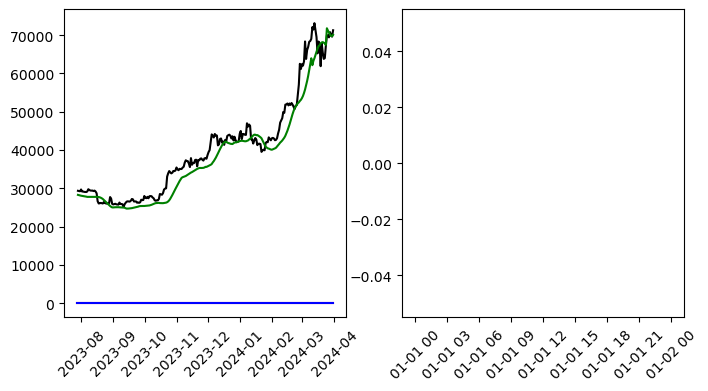

In [13]:
# Plot the results
fig, ax = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(8)
actual_df = BTC.history.loc[pred_df.index[0]: pred_df.index[-1]]
ax[0].plot(actual_df.index, actual_df['close'], color = 'black', label = 'Actual')
ax[0].plot(pred_df.index, pred_df['Predicted price'], color = 'green', label = 'Predicted')
ax[0].plot(my_portfolio.value.index, my_portfolio.value['value'], color = 'red', label = 'Experimental Portfolio')
ax[0].plot(ref_portfolio.value.index, ref_portfolio.value['value'], color = 'blue', label = 'Reference Portfolio')
for tick in ax[0].get_xticklabels():
        tick.set_rotation(45)

ax[1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - ref_portfolio.value['value'])/ref_portfolio.value['value'], color = 'black', label = 'ROI')
for tick in ax[1].get_xticklabels():
        tick.set_rotation(45)